# Investigation of Multivariate Data Imputation Techniques for Sparse Data of Varying Dimensionality
We carry a further investigation in addition to one done by Bryan Moore and Priyanka Chakraborti in 2019 on the missing data problem. We focus our investogation on multivariate impitation through the utilization of the Multiple Imputation through Chained Equations (MICE) approach. Our investigation uses two datasets, one containing sparse data, and one containing complete data on which we induce a random form of missingness. The complete dataset is used as the base to measure performance of the models on different datasets.

## Importing the necessary libraries and setting of global variables

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer # noqa
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

import fancyimpute
import missingpy

%matplotlib inline

pd.options.display.max_columns = None

# Global varaibles
CORR_THRESHOLD = 0.10
FEATURE_COLUMNS = []
column_names = ['Dataset', 'Imputation Strategy', 'Train r^2 score', 'Prediction r^2 score']
RESULTS_SUMMARY = pd.DataFrame(columns=column_names)

## Helper Functions

In [20]:
# Drop a fraction of columns
def drop_column_frac(df:pd.DataFrame, column_name:str, replace_with, drop_frac=0.1) -> pd.DataFrame:
    drop_idx = df[column_name].sample(frac=drop_frac).index
    dropped_df = df.copy()
    dropped_df.loc[drop_idx, column_name] = replace_with
    return dropped_df

# Drop columns 
def drop_columns(df:pd.DataFrame, columns_to_drop: list) -> pd.DataFrame:
    return df.drop(columns=columns_to_drop)

# Drop NAs
def drop_nas(df:pd.DataFrame) -> pd.DataFrame:
    return df.dropna()

# Returns best_score_, best_params_, grid_search object
def grid_search(X:np.array, y:np.array, pipeline: Pipeline, params_grid: dict, n_jobs=10) -> (float, dict, float):
    search = GridSearchCV(pipeline, params_grid, n_jobs=n_jobs)
    search.fit(X, y)
    return search.best_score_, search.best_params_, search

# Run pipeline
def run_pipeline(X_train:np.array, y_train:np.array, X_test:np.array, y_test:np.array, pipeline: Pipeline, params_grid: dict) -> [float, float]:
    # Set Parameters
    pipeline.set_params(**params_grid)
    # Fit data
    pipeline.fit(X_train, y_train)
    # Predict data
    y_predicted = pipeline.predict(X_test)
    # Calculate scores
    mean_error = mean_squared_error(y_test, y_predicted)
    r2_score_val = r2_score(y_test, y_predicted)

    return (mean_error, r2_score_val)

# Zillow Dataset
## Data Preprocessing on Zillow Data
### Read in data and set true target

In [21]:
# Using training data set since the properties datasets are HUGE
zillow_df = pd.read_csv('data/zillow/properties_2016_small.csv')

#Set true target
TRUE_TARGET = 'taxvaluedollarcnt'

# Check the data
zillow_df.head()


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [4]:
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 58 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      50000 non-null  int64  
 1   airconditioningtypeid         13956 non-null  float64
 2   architecturalstyletypeid      98 non-null     float64
 3   basementsqft                  30 non-null     float64
 4   bathroomcnt                   50000 non-null  float64
 5   bedroomcnt                    50000 non-null  float64
 6   buildingclasstypeid           253 non-null    float64
 7   buildingqualitytypeid         33170 non-null  float64
 8   calculatedbathnbr             47845 non-null  float64
 9   decktypeid                    330 non-null    float64
 10  finishedfloor1squarefeet      3913 non-null   float64
 11  calculatedfinishedsquarefeet  49271 non-null  float64
 12  finishedsquarefeet12          45559 non-null  float64
 13  f

### Describe numerical attributes

In [5]:
zillow_df.describe()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
count,5.000000e+04,13956.000000,98.000000,30.000000,50000.000000,50000.000000,253.000000,33170.000000,47845.000000,330.0,3913.000000,49271.000000,45559.000000,158.000000,3226.000000,3913.000000,328.000000,50000.000000,5322.000000,47845.000000,14181.000000,14181.000000,30821.000000,5.000000e+04,5.000000e+04,4.570200e+04,8930.0,500.000000,579.0,503.0,8427.0,50000.000000,5.000000e+04,49193.000000,50000.000000,20124.000000,49962.000000,49999.000000,30.0,4943.000000,102.0,33814.000000,1590.000000,48.000000,49185.000000,11157.000000,4.914000e+04,4.938300e+04,50000.000000,4.897500e+04,4.966200e+04,982.000000,4.874600e+04
mean,1.291099e+07,1.856549,7.244898,582.133333,2.213940,3.073680,3.774704,5.768405,2.312697,66.0,1368.353948,1839.130868,1768.944336,1207.284810,2811.753255,1376.759264,2326.265244,6048.313640,1.165727,2.260571,1.825823,384.116212,3.939295,3.401981e+07,-1.182316e+08,2.354319e+04,1.0,524.060000,1.0,1.0,1.0,259.838840,6.048630e+07,35065.083487,2603.822500,186472.041940,96553.642769,1.430509,7.0,1.009104,6.0,1.177086,315.225157,274.520833,1964.138111,1.393654,1.743610e+05,4.250374e+05,2014.999400,2.536299e+05,5.429598e+03,13.924644,6.048719e+13
std,2.715179e+06,3.027129,2.134939,377.238124,1.100229,1.282281,0.463587,1.828840,1.017500,0.0,631.386276,1707.423411,938.246696,344.763633,5550.172268,666.085896,1516.009057,21.267356,0.466069,1.008393,0.618804,248.983008,3.142905,2.444140e+05,3.530757e+05,1.103865e+05,0.0,167.842434,0.0,0.0,0.0,17.309375,2.111605e+05,52308.000732,765.369644,168052.712476,3857.246708,2.831305,0.0,0.117809,0.0,1.556302,273.323359,283.313374,23.357180,0.532308,3.943717e+05,6.788362e+05,0.056918,4.169578e+05,9.155317e+03,1.533328,2.116470e+11
min,1.071177e+07,1.000000,2.000000,63.000000,0.000000,0.000000,2.000000,1.000000,1.000000,66.0,47.000000,60.000000,60.000000,470.000000,148.000000,47.000000,384.000000,6037.000000,1.000000,1.000000,0.000000,0.000000,2.000000,3.333938e+07,-1.194484e+08,1.290000e+02,1.0,64.000000,1.0,1.0,1.0,31.000000,6.037101e+07,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,7.0,1.000000,6.0,1.000000,24.000000,14.000000,1862.000000,1.000000,5.000000e+00,8.000000e+00,2003.000000,4.000000e+00,5.020000e+00,6.000000,6.037101e+13
25%,1.152476e+07,1.000000,7.000000,221.000000,2.000000,2.000000,4.000000,4.000000,2.000000,66.0,1012.000000,1217.000000,1200.000000,1000.000000,1696.000000,1012.000000,1187.000000,6037.000000,1.000000,2.000000,2.000000,322.000000,2.000000,3.384708e+07,-1.184233e+08,5.720000e+03,1.0,440.000000,1.0,1.0,1.0,261.000000,6.037301e+07,12447.000000,2061.000000,41131.000000,96173.000000,0.000000,7.0,1.000000,6.0,1.000000,180.000000,99.000000,1950.000000,1.000000,7.548775e+04,1.781575e+05,2015.000000,7.266550e+04,2.448312e+03,14.000000,6.037301e+13
50%,1.242189e+07,1.000000,7.000000,547.000000,2.000000,3.000000,4.000000,7.000000,2.000000,66.0,1284.000000,1577.000000,1545.000000,1296.000000,2175.000000,1285.000000,1958.500000,6037.000000,1.000000,2.000000,2.000000,441.000000,2.000000,3.403083e+07,-1.182048e+08,7.033000e+03,1.0,500.000000,1.0,1.0,1.0,261.000000,6.037571e+07,24832.000000,3101.000000,118208

### Describe categorical data

In [22]:
# Value Counts for Categorical Columns

# Print the value counts for categorical columns
for col in zillow_df.columns:
    if zillow_df[col].dtype == 'object':
        print('\nColumn Name:', col,)
        print(zillow_df[col].value_counts())


Column Name: hashottuborspa
True    1082
Name: hashottuborspa, dtype: int64

Column Name: propertycountylandusecode
0100    19608
122      7862
0101     4447
010C     3876
1111     2440
        ...  
105         1
0140        1
1014        1
010T        1
020G        1
Name: propertycountylandusecode, Length: 99, dtype: int64

Column Name: propertyzoningdesc
LAR1      5090
LAR3      1190
LARS      1045
LAR2       858
LBR1N      780
          ... 
WCSC*        1
C1-R2        1
DUPUD        1
HPR2*        1
GAR2YY       1
Name: propertyzoningdesc, Length: 1773, dtype: int64

Column Name: fireplaceflag
True    79
Name: fireplaceflag, dtype: int64

Column Name: taxdelinquencyflag
Y    982
Name: taxdelinquencyflag, dtype: int64


### Drop all categorical data OR Label encode them
There are so many distinct values in the categorical data and hence one-hot encoding would increase the dimension of the data exponentially. In this instance, we decide to label encode the categorical data

In [24]:
# Select the categorical columns
cat_cols = zillow_df.select_dtypes(include='object').columns

# # Instantiate encoder
# encoder = LabelEncoder()
# # Encode the categorical data
# for col in cat_cols:
#     print(col)
#     zillow_df[col] = encoder.fit_transform(zillow_df[col])

# Drop the columns
zillow_df = zillow_df.drop(columns=cat_cols)

### Calculate correlation coefficients against target column

In [25]:
correlation_array = zillow_df.corr()[TRUE_TARGET].sort_values(ascending=False)
correlation_array

taxvaluedollarcnt               1.000000
taxamount                       0.963647
landtaxvaluedollarcnt           0.847662
structuretaxvaluedollarcnt      0.834219
finishedsquarefeet15            0.658055
finishedsquarefeet12            0.636250
finishedfloor1squarefeet        0.574428
finishedsquarefeet50            0.565945
poolsizesum                     0.520322
calculatedfinishedsquarefeet    0.509469
calculatedbathnbr               0.495457
fullbathcnt                     0.481303
basementsqft                    0.465104
fireplacecnt                    0.454990
garagecarcnt                    0.369250
bathroomcnt                     0.360499
garagetotalsqft                 0.356908
threequarterbathnbr             0.348244
yardbuildingsqft17              0.289622
unitcnt                         0.197026
finishedsquarefeet6             0.178706
numberofstories                 0.175817
bedroomcnt                      0.161504
finishedsquarefeet13            0.158479
yearbuilt       

### Drop perfectly correlated and redudant features

In [26]:
PERFECT_COR = ['taxamount', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt']

# Only keep colms that have correlation coeff greater than CORR_THRESHOLD
colms_to_keep = correlation_array[correlation_array > CORR_THRESHOLD]
# Only keep the best correlated columns
parsed_zillow_df = zillow_df[colms_to_keep.index]

# Drop perfect correlations
parsed_zillow_df = parsed_zillow_df.drop(columns=PERFECT_COR)

### Number of NAN values in target column

In [27]:
# Number of NANs in target column
num_nan = parsed_zillow_df[TRUE_TARGET].isna().sum()
print('Number of NANs in target column is: ', num_nan)

Number of NANs in target column is:  617


### Drop rows with NAN values in target column

In [28]:
# Drop rows with NAN in target column
parsed_zillow_df = parsed_zillow_df.dropna(subset=[TRUE_TARGET], how='any')
# Shuffle data
parsed_zillow_df = parsed_zillow_df.sample(frac=1)
print('Shape of data after dropping NAN values in target column: ', parsed_zillow_df.shape)

Shape of data after dropping NAN values in target column:  (49383, 22)


### Create feature and target matrix

In [29]:
# Extract target
target = parsed_zillow_df[TRUE_TARGET]

# Extract features
X_original = parsed_zillow_df.drop(columns=[TRUE_TARGET])

# Columns to be used for pair plots
FEATURE_COLUMNS = X_original.columns.to_numpy()

# Check the structure of the data
print('Shape of feature matrix: ', X_original.shape)
print('Shape of target matrix: ', target.shape)

Shape of feature matrix:  (49383, 21)
Shape of target matrix:  (49383,)


### Generate correlation map for missing values in feature matrix

In [10]:
# Function to plot correlation for variables with NAN values
def correlationMatrix(df, dropDuplicates = True):
    """Plot correlation matrix"""
    # Calculate correlation
    df_corr = df.corr()

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df_corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(15, 12))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df_corr, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df_corr, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)

In [14]:
# Columns of rows with NAN values
nan_values = X_original.isna()
nan_columns = nan_values.any()

# Dataframe with columns that have got NAN values
X_original_nan = X_original[(nan_columns[nan_columns == True]).index]

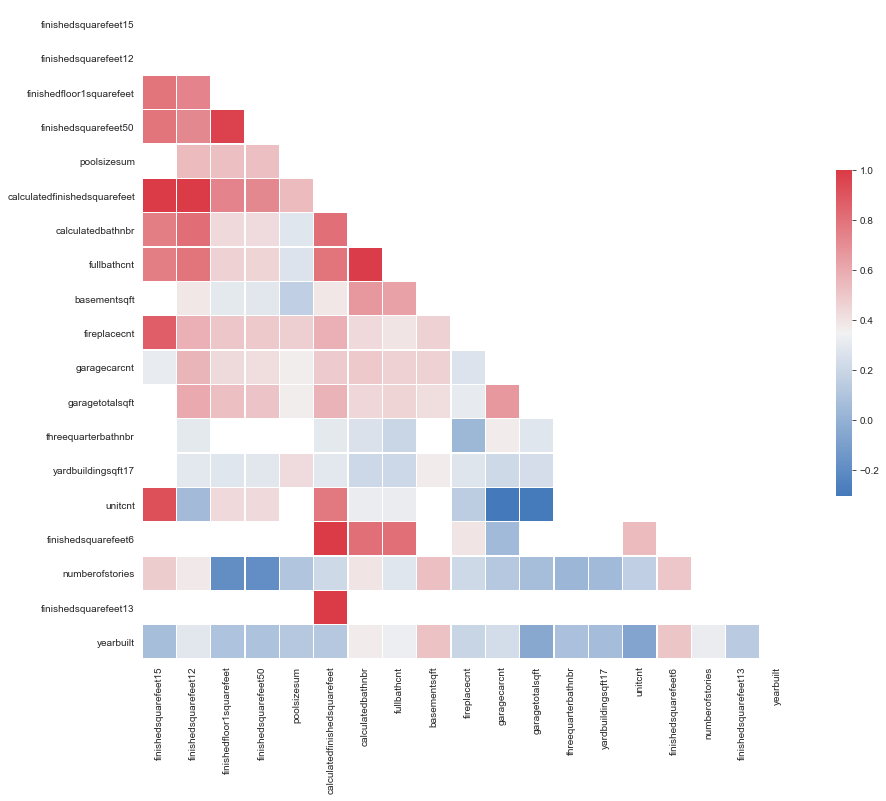

In [15]:
# Plot the correlation matrix for the variables containing NAN values
# This will help us determine the variables whose covariance is likely to be affected after
# imputation and also which varibales can be used together when imputing
correlationMatrix(X_original_nan, dropDuplicates = True)

# Multivariate Imputation on Zillow Data
Before getting into using various models to perform imputation, we prform mean imputation to create a base for comparison for our models. We then use the state of the art MICE imputation and finally we perform imputation using the various chosen models. 

## Mean Imputation 

In [30]:
# Instantiate mean imputer
simple_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# Impute
X_missing_mean = X_original.copy()
X_imputed_mean = simple_imputer.fit_transform(X_missing_mean)

# Partition the data into train and test data
X_train_mean, X_test_mean, Y_train_mean, Y_test_mean = train_test_split(X_imputed_mean, target.values, test_size=0.2)

### Hyperparameter tuning base estimator model
We perform hyperparameter tuning to determine the best base model to predict on the imputed data

In [31]:
# Parameters
param_grid = {'bayesianridge__n_iter': [1000, 10000], 'bayesianridge__tol': [0.00001, 0.0000001], 'bayesianridge__alpha_1': [0.1, 0.01],
                'bayesianridge__lambda_1': [1, 0, 0.1, 0.01]}

# Regressor
br_estimator_mean = BayesianRidge()
# Scaler
scaler_mean = StandardScaler()
# Estimator
estimator_mean = make_pipeline(scaler_mean, br_estimator_mean)
# Grid search
mean_imputer_score, mean_imputer_params, mean_search = grid_search(X_train_mean, Y_train_mean, estimator_mean, param_grid)
print('Best model paramemeters: ' , mean_imputer_params)

Best model paramemeters:  {'bayesianridge__alpha_1': 0.01, 'bayesianridge__lambda_1': 0, 'bayesianridge__n_iter': 1000, 'bayesianridge__tol': 1e-07}


### Model evaluation

In [32]:
# Model evaluation
br_estimator_mean = BayesianRidge()
# Scaler
scaler_mean = StandardScaler()
# Estimator
estimator_mean_eval = make_pipeline(scaler_mean, br_estimator_mean)

#Scores
train_mean_error, train_r2_score = run_pipeline(X_train_mean, Y_train_mean, X_train_mean, Y_train_mean, estimator_mean_eval, mean_imputer_params)
test_mean_error, test_r2_score = run_pipeline(X_train_mean, Y_train_mean, X_test_mean, Y_test_mean, estimator_mean_eval, mean_imputer_params)

# Append to results dataframe
RESULTS_SUMMARY = RESULTS_SUMMARY.append({'Dataset': 'Zillow', 'Imputation Strategy': 'Mean', 'Train r^2 score': train_r2_score,
                                            'Prediction r^2 score': test_r2_score}, ignore_index=True)

# Print results
print('----------------------------Model Train---------------------------------')
print('\nTrain mean squared error is: %0.4f' % train_mean_error)
print('Train r^2 variance score: %0.4f' % train_r2_score)
print('\n----------------------------Model Evaluation---------------------------------')
print('Test mean squared error is: %0.4f' % test_mean_error)
print('Test r^2 variance score: %0.4f' % test_r2_score)

----------------------------Model Train---------------------------------

Train mean squared error is: 210407531487.2488
Train r^2 variance score: 0.4016

----------------------------Model Evaluation---------------------------------
Test mean squared error is: 734780693245.4471
Test r^2 variance score: 0.1810


## MICE with OLS Linear Regression
### Hyperparameter tuning for imputer estimator model

In [33]:
# Copy feature matrix
X_missing_gd = X_original.copy()

In [19]:
# Parameters
param_grid_gd = {'iterativeimputer__n_nearest_features': [3, 5, 7], 'iterativeimputer__estimator__n_iter':  [1000],
                 'iterativeimputer__estimator__tol': [0.00001],'iterativeimputer__estimator__alpha_1': [0.1, 0.01],
                'iterativeimputer__estimator__lambda_1': [1, 0.1]}

# Regressor
br_estimator_gd = BayesianRidge()
# Instantiate mean imputer
iterative_imputer_gd = IterativeImputer(estimator=BayesianRidge())
# Scaler
scaler_gd = StandardScaler()
# Impute
estimator_gd = make_pipeline(iterative_imputer_gd, scaler_gd, br_estimator_gd)
# Grid search
grid_iterative_imputer_score_gd, grid_iterative_imputer_params_gd, grid_iterative_search_gd = grid_search(X_missing_gd, target, estimator_gd, param_grid_gd)
print('Best BayesianRidge imputer paramemeters: ' , grid_iterative_imputer_params_gd)

Best BayesianRidge imputer paramemeters:  {'iterativeimputer__estimator__alpha_1': 0.1, 'iterativeimputer__estimator__lambda_1': 0.1, 'iterativeimputer__estimator__n_iter': 1000, 'iterativeimputer__estimator__tol': 1e-05, 'iterativeimputer__n_nearest_features': 3}


In [34]:
# Instantiate iterative imputer
iterative_imputer_gd = IterativeImputer(estimator=BayesianRidge(alpha_1=0.1, lambda_1=0.1, n_iter=1000, tol=1e-05), n_nearest_features=3)
# Impute
X_imputed_gd = iterative_imputer_gd.fit_transform(X_missing_gd)

# Partition the data into train and test data
X_train_gd, X_test_gd, Y_train_gd, Y_test_gd = train_test_split(X_imputed_gd, target.values, test_size=0.2)

### Hyperparameter tuning for base estimator model

In [35]:
# Parameters
param_grid_gd = {'bayesianridge__n_iter': [1000, 10000], 'bayesianridge__tol': [0.00001, 0.0000001], 'bayesianridge__alpha_1': [0.1, 0.01]}

# Regressor
br_estimator_gd = BayesianRidge()
# Scaler
scaler_gd = StandardScaler()
# Impute
estimator_gd = make_pipeline(scaler_gd, br_estimator_gd)
# Grid search
iterative_imputer_score_gd, iterative_imputer_params_gd, iterative_search_gd = grid_search(X_train_gd, Y_train_gd, estimator_gd, param_grid_gd)
print('Best BayesianRidge model paramemeters: ' , iterative_imputer_params_gd)

Best BayesianRidge model paramemeters:  {'bayesianridge__alpha_1': 0.01, 'bayesianridge__n_iter': 1000, 'bayesianridge__tol': 1e-07}


### Model evaluation

In [36]:
# Model evaluation
br_estimator_gd = BayesianRidge()
# Scaler
scaler_gd = StandardScaler()

# Estimator
estimator_gd_eval = make_pipeline(scaler_gd, br_estimator_gd)

# Scores
train_mean_error, train_r2_score = run_pipeline(X_train_gd, Y_train_gd, X_train_gd, Y_train_gd, estimator_gd_eval, iterative_imputer_params_gd)
test_mean_error, test_r2_score = run_pipeline(X_train_gd, Y_train_gd, X_test_gd, Y_test_gd, estimator_gd_eval, iterative_imputer_params_gd)

# Append to results dataframe
RESULTS_SUMMARY = RESULTS_SUMMARY.append({'Dataset': 'Zillow', 'Imputation Strategy': 'BayesianRidge', 'Train r^2 score': train_r2_score,
                                            'Prediction r^2 score': test_r2_score}, ignore_index=True)

# Print results
print('----------------------------Model Train---------------------------------')
print('\nTrain mean squared error is: %0.4f' % train_mean_error)
print('Train r^2 variance score: %0.4f' % train_r2_score)
print('\n----------------------------Model Evaluation---------------------------------')
print('Test mean squared error is: %0.4f' % test_mean_error)
print('Test r^2 variance score: %0.4f' % test_r2_score)

----------------------------Model Train---------------------------------

Train mean squared error is: 216415462381.6988
Train r^2 variance score: 0.3887

----------------------------Model Evaluation---------------------------------
Test mean squared error is: 740990650781.5740
Test r^2 variance score: 0.1653


## MICE with K-Neighbours Regressor
### Hyperparameter tuning for imputer  estimator model

In [37]:
# Copy feature matrix
X_missing_knn = X_original.copy()

In [25]:
# Parameters
param_grid_knn = {'iterativeimputer__n_nearest_features': [3, 5], 'iterativeimputer__estimator__n_neighbors':  [5, 10],
                 'iterativeimputer__estimator__weights': ['uniform', 'distance'],'iterativeimputer__estimator__p': [1, 2]}

# Regressor
br_estimator_knn = BayesianRidge()
# Instantiate knn imputer
iterative_imputer_knn = IterativeImputer(estimator=KNeighborsRegressor())
# Scaler
scaler_knn = StandardScaler()
# Estimator
estimator_knn = make_pipeline(iterative_imputer_knn, scaler_knn, br_estimator_knn)
# Grid search
grid_iterative_imputer_score_knn, grid_iterative_imputer_params_knn, grid_iterative_search_knn = grid_search(X_missing_knn, target, estimator_knn, param_grid_knn)
print('Best KNeighborsRegressor imputer paramemeters: ' , grid_iterative_imputer_params_knn)

Best KNeighborsRegressor imputer paramemeters:  {'iterativeimputer__estimator__n_neighbors': 5, 'iterativeimputer__estimator__p': 1, 'iterativeimputer__estimator__weights': 'uniform', 'iterativeimputer__n_nearest_features': 5}


### Best KNeighborsRegressor imputation

In [38]:
# Instantiate iterative imputer
iterative_imputer_knn = IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=5, p=1, weights='uniform'), n_nearest_features=5)
# Impute
X_imputed_knn = iterative_imputer_knn.fit_transform(X_missing_gd)

# Partition the data into train and test data
X_train_knn, X_test_knn, Y_train_knn, Y_test_knn = train_test_split(X_imputed_knn, target.values, test_size=0.2)

### Hyperparameter tuning for base estimator model


In [39]:
# Parameters
param_grid_knn = {'bayesianridge__n_iter': [1000, 10000], 'bayesianridge__tol': [0.00001, 0.0000001], 'bayesianridge__alpha_1': [0.1, 0.01]}

# Regressor
br_estimator_knn = BayesianRidge()
# Scaler
scaler_knn = StandardScaler()
# Impute
estimator_knn = make_pipeline(scaler_knn, br_estimator_knn)
# Grid search
iterative_imputer_score_knn, iterative_imputer_params_knn, iterative_search_knn = grid_search(X_train_knn, Y_train_knn, estimator_knn, param_grid_knn)
print('Best BayesianRidge base model paramemeters: ' , iterative_imputer_params_knn)

Best BayesianRidge base model paramemeters:  {'bayesianridge__alpha_1': 0.01, 'bayesianridge__n_iter': 1000, 'bayesianridge__tol': 1e-05}


### Model evaluation

In [40]:
# Model evaluation
br_estimator_knn = BayesianRidge()
# Scaler
scaler_knn = StandardScaler()

# Estimator
estimator_knn_eval = make_pipeline(scaler_knn, br_estimator_knn)

# Scores
train_mean_error, train_r2_score = run_pipeline(X_train_knn, Y_train_knn, X_train_knn, Y_train_knn, estimator_knn_eval, iterative_imputer_params_knn)
test_mean_error, test_r2_score = run_pipeline(X_train_knn, Y_train_knn, X_test_knn, Y_test_knn, estimator_knn_eval, iterative_imputer_params_knn)

# Append to results dataframe
RESULTS_SUMMARY = RESULTS_SUMMARY.append({'Dataset': 'Zillow', 'Imputation Strategy': 'KNeighboursRegressor', 'Train r^2 score': train_r2_score,
                                            'Prediction r^2 score': test_r2_score}, ignore_index=True)

# Print results
print('----------------------------Model Train---------------------------------')
print('\nTrain mean squared error is: %0.4f' % train_mean_error)
print('Train r^2 variance score: %0.4f' % train_r2_score)
print('\n----------------------------Model Evaluation---------------------------------')
print('Test mean squared error is: %0.4f' % test_mean_error)
print('Test r^2 variance score: %0.4f' % test_r2_score)

----------------------------Model Train---------------------------------

Train mean squared error is: 336726432639.8325
Train r^2 variance score: 0.3175

----------------------------Model Evaluation---------------------------------
Test mean squared error is: 203249358560.4454
Test r^2 variance score: 0.3850


## MICE with RandomForest Regressor

### Hyperparameter tuning for RandomForest imputer model

In [41]:
# Copy feature matrix
X_missing_rf = X_original.copy()

In [16]:
# Parameters
param_grid_rf = {'iterativeimputer__n_nearest_features': [3, 5], 'iterativeimputer__estimator__n_estimators':  [100, 200],
                 'iterativeimputer__estimator__min_samples_split': [2, 5],'iterativeimputer__estimator__max_depth': [10, None]}

# Regressor
br_estimator_rf = BayesianRidge()
# Instantiate knn imputer
iterative_imputer_rf = IterativeImputer(estimator=RandomForestRegressor())
# Scaler
scaler_rf = StandardScaler()
# Estimator
estimator_rf = make_pipeline(iterative_imputer_rf, scaler_rf, br_estimator_rf)
# Grid search
grid_iterative_imputer_score_rf, grid_iterative_imputer_params_rf, grid_iterative_search_rf = grid_search(X_missing_rf, target, estimator_rf, param_grid_rf)
print('Best RandomForestRegressor imputer paramemeters: ' , grid_iterative_imputer_params_rf)

Best RandomForestRegressor imputer paramemeters:  {'iterativeimputer__estimator__max_depth': 10, 'iterativeimputer__estimator__min_samples_split': 5, 'iterativeimputer__estimator__n_estimators': 200, 'iterativeimputer__n_nearest_features': 3}


### Best RandomForestRegressor imputation

In [42]:
# Instantiate iterative imputer
iterative_imputer_rf = IterativeImputer(estimator=RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=200, ), n_nearest_features=3)
# Impute
X_imputed_rf = iterative_imputer_rf.fit_transform(X_missing_rf)

# Partition the data into train and test data
X_train_rf, X_test_rf, Y_train_rf, Y_test_rf = train_test_split(X_imputed_rf, target.values, test_size=0.2)

### Hyperparameter tuning for base estimator model

In [43]:
# Parameters
param_grid_rf = {'bayesianridge__n_iter': [1000, 10000], 'bayesianridge__tol': [0.00001, 0.0000001], 'bayesianridge__alpha_1': [0.1, 0.01]}

# Regressor
br_estimator_rf = BayesianRidge()
# Scaler
scaler_rf = StandardScaler()
# Impute
estimator_rf = make_pipeline(scaler_rf, br_estimator_rf)
# Grid search
iterative_imputer_score_rf, iterative_imputer_params_rf, iterative_search_rf = grid_search(X_train_rf, Y_train_rf, estimator_rf, param_grid_rf)
print('Best DecisionTreeRegressor base model paramemeters: ' , iterative_imputer_params_rf)

Best DecisionTreeRegressor base model paramemeters:  {'bayesianridge__alpha_1': 0.01, 'bayesianridge__n_iter': 1000, 'bayesianridge__tol': 1e-05}


### Model evaluation

In [45]:
# Model evaluation
br_estimator_rf = BayesianRidge()
# Scaler
scaler_rf = StandardScaler()

# Estimator
estimator_rf_eval = make_pipeline(scaler_rf, br_estimator_rf)

# Scores
train_mean_error, train_r2_score = run_pipeline(X_train_rf, Y_train_rf, X_train_rf, Y_train_rf, estimator_rf_eval, iterative_imputer_params_rf)
test_mean_error, test_r2_score = run_pipeline(X_train_rf, Y_train_rf, X_test_rf, Y_test_rf, estimator_rf_eval, iterative_imputer_params_rf)

# Append to results dataframe
RESULTS_SUMMARY = RESULTS_SUMMARY.append({'Dataset': 'Zillow', 'Imputation Strategy': 'RandomForest', 'Train r^2 score': train_r2_score,
                                            'Prediction r^2 score': test_r2_score}, ignore_index=True)

# Print results
print('----------------------------Model Train---------------------------------')
print('\nTrain mean squared error is: %0.4f' % train_mean_error)
print('Train r^2 variance score: %0.4f' % train_r2_score)
print('\n----------------------------Model Evaluation---------------------------------')
print('Test mean squared error is: %0.4f' % test_mean_error)
print('Test r^2 variance score: %0.4f' % test_r2_score)

----------------------------Model Train---------------------------------

Train mean squared error is: 229013533856.8918
Train r^2 variance score: 0.3935

----------------------------Model Evaluation---------------------------------
Test mean squared error is: 641675533389.9901
Test r^2 variance score: 0.1915


## MICE with MLPRegressor Regressor

### Hyperparameter tuning for MLPRegressr model

In [46]:
# Copy feature matrix
X_missing_mlp = X_original.copy()

In [20]:
# Parameters
param_grid_mlp = {'iterativeimputer__n_nearest_features': [3, 5], 'iterativeimputer__estimator__hidden_layer_sizes':  [50, 100],
                 'iterativeimputer__estimator__alpha': [0.1, 0.001],'iterativeimputer__estimator__tol': [0.001, 0.0001]}

# Regressor
br_estimator_mlp = BayesianRidge()
# Instantiate knn imputer
iterative_imputer_mlp = IterativeImputer(estimator=MLPRegressor())
# Scaler
scaler_mlp = StandardScaler()
# Estimator
estimator_mlp = make_pipeline(iterative_imputer_mlp, scaler_mlp, br_estimator_mlp)
# Grid search
grid_iterative_imputer_score_mlp, grid_iterative_imputer_params_mlp, grid_iterative_search_mlp = grid_search(X_missing_mlp, target, estimator_mlp, param_grid_mlp)
print('Best MLPRegressor imputer paramemeters: ' , grid_iterative_imputer_params_mlp)

Best MLPRegressor imputer paramemeters:  {'iterativeimputer__estimator__alpha': 0.001, 'iterativeimputer__estimator__hidden_layer_sizes': 100, 'iterativeimputer__estimator__tol': 0.001, 'iterativeimputer__n_nearest_features': 3}


### Best MLPRegressor imputation

In [47]:
# Instantiate iterative imputer
iterative_imputer_mlp = IterativeImputer(estimator=MLPRegressor(alpha=0.001, hidden_layer_sizes=100, tol=0.001), n_nearest_features=3)
# Impute
X_imputed_mlp = iterative_imputer_mlp.fit_transform(X_missing_mlp)

# Partition the data into train and test data
X_train_mlp, X_test_mlp, Y_train_mlp, Y_test_mlp = train_test_split(X_imputed_mlp, target.values, test_size=0.2)

### Hyperparameter tuning for base estimator model

In [48]:
# Parameters
param_grid_mlp = {'bayesianridge__n_iter': [1000, 10000], 'bayesianridge__tol': [0.00001, 0.0000001], 'bayesianridge__alpha_1': [0.1, 0.01]}


# Regressor
br_estimator_mlp = BayesianRidge()
# Scaler
scaler_mlp = StandardScaler()
# Impute
estimator_mlp = make_pipeline(scaler_mlp, br_estimator_mlp)
# Grid search
iterative_imputer_score_mlp, iterative_imputer_params_mlp, iterative_search_mlp = grid_search(X_train_mlp, Y_train_mlp, estimator_mlp, param_grid_mlp)
print('Best BayesianRidge base model paramemeters: ' , iterative_imputer_params_mlp)

Best BayesianRidge base model paramemeters:  {'bayesianridge__alpha_1': 0.01, 'bayesianridge__n_iter': 1000, 'bayesianridge__tol': 1e-07}


### Model evaluation

In [51]:
# Model evaluation
br_estimator_mlp = BayesianRidge()
# Scaler
scaler_mlp = StandardScaler()

# Estimator
estimator_mlp_eval = make_pipeline(scaler_mlp, br_estimator_mlp)

# Scores
train_mean_error, train_r2_score = run_pipeline(X_train_mlp, Y_train_mlp, X_train_mlp, Y_train_mlp, estimator_mlp_eval, iterative_imputer_params_mlp)
test_mean_error, test_r2_score = run_pipeline(X_train_mlp, Y_train_mlp, X_test_mlp, Y_test_mlp, estimator_mlp_eval, iterative_imputer_params_mlp)

# Append to results dataframe
RESULTS_SUMMARY = RESULTS_SUMMARY.append({'Dataset': 'Zillow', 'Imputation Strategy': 'MLP', 'Train r^2 score': train_r2_score,
                                            'Prediction r^2 score': test_r2_score}, ignore_index=True)

# Print results
print('----------------------------Model Train---------------------------------')
print('\nTrain mean squared error is: %0.4f' % train_mean_error)
print('Train r^2 variance score: %0.4f' % train_r2_score)
print('\n----------------------------Model Evaluation---------------------------------')
print('Test mean squared error is: %0.4f' % test_mean_error)
print('Test r^2 variance score: %0.4f' % test_r2_score)

----------------------------Model Train---------------------------------

Train mean squared error is: 290631051230.6285
Train r^2 variance score: 0.3154

----------------------------Model Evaluation---------------------------------
Test mean squared error is: 398435058496.1864
Test r^2 variance score: 0.3422


# Results
A summary of the r^2 score for all the models run agaisnt each daset is as shown in the table below. We see that the __ strategy perfomrs the best on sparse data (zillow dataset)and that all models perform pretty well on the Boston housing dataset.

In [63]:
# Results summaru
RESULTS_SUMMARY.head(10)

,Dataset,Imputation Strategy,Train r^2 score,Prediction r^2 score
0,Zillow,Mean,0.401598,0.181020
1,Zillow,BayesianRidge,0.388733,0.165326
2,Zillow,KNeighboursRegressor,0.317524,0.384981
4,Zillow,RandomForest,0.393469,0.191547
5,Zillow,MLP,0.315377,0.342243


### Graph of results 

<AxesSubplot:xlabel='Train r^2 score', ylabel='Prediction r^2 score'>

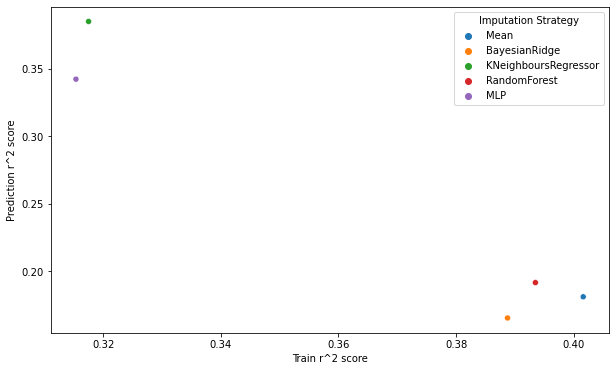

In [104]:
fig = plt.gcf()
fig.set_size_inches(10,6)
sns.scatterplot(data=RESULTS_SUMMARY, x="Train r^2 score", y="Prediction r^2 score", hue="Imputation Strategy")

# Boston Census Dataset
## NOTE: This is sort of an appendix to the previous discussion about why we didn't end up using the Boston census data. See the report for more details

## Data Preprocessing on Boston Census Data
### Read in data and set true target

In [3]:
ADULT_TRUE_TARGET = 'target'

# Need to specify column names since they didn't come in the csv
columns = [
    'age',
    'workclass',
    'final_weight', # this is number of people census thinks represented by this row
    'education',
    'education_num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital_gain',
    'capital_loss',
    'hrs-per-week',
    'native-country',
    'income_class'
]
adult_df = pd.read_csv('data/adult.csv', delimiter=', ', names=columns)

# Create target column based on income_class and drop the existing income columns
adult_df[ADULT_TRUE_TARGET] = (adult_df['income_class']=='>50K').astype(int)
adult_df = adult_df.drop(columns=['income_class'])

## Some Basic Data Exploration

### Note there are no null values. We will drop data to simulate missing data (the process used for that is described below)

In [4]:
# Show object types and non-null values
adult_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   final_weight    32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hrs-per-week    32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  target          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


In [5]:
# Basic column info
adult_df.describe()

,age,final_weight,education_num,capital_gain,capital_loss,hrs-per-week,target
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456,0.240810
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429,0.427581
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faaefa60d60>,
      dtype=object)

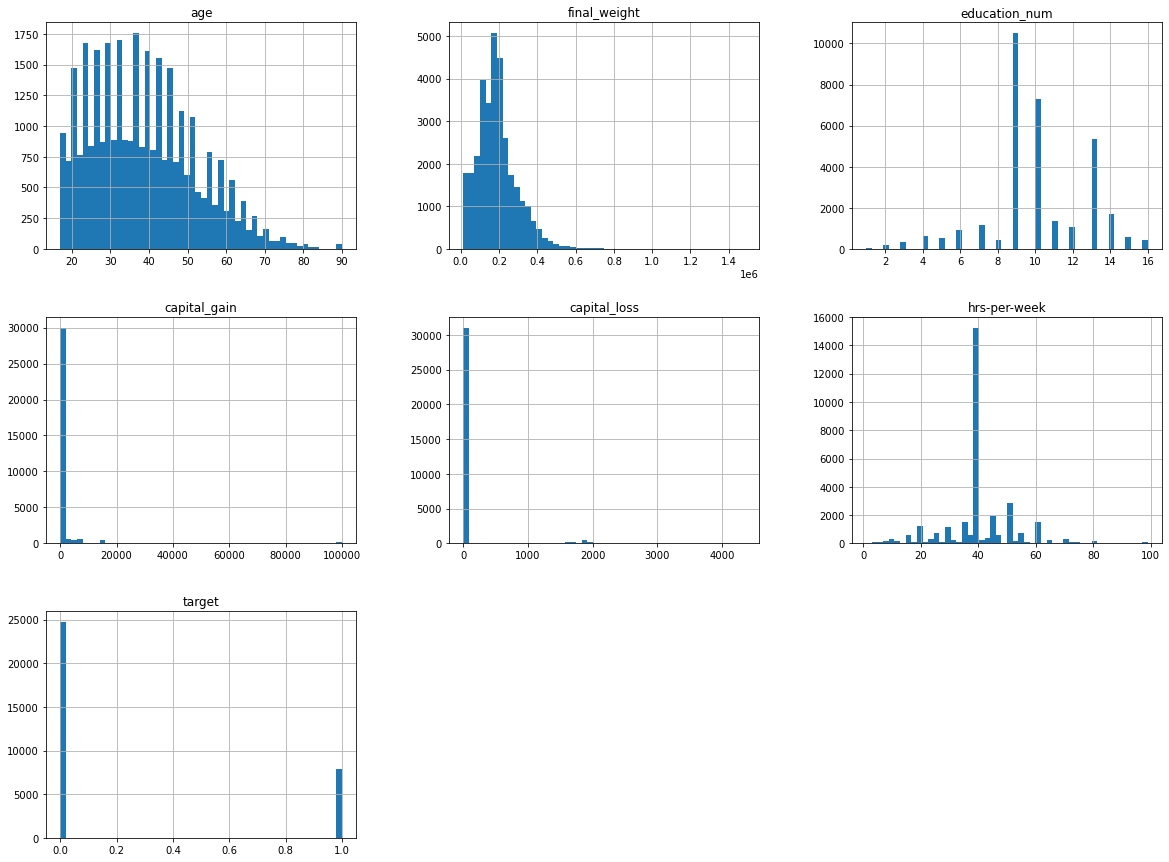

In [6]:
# Histogram of variables
adult_df.hist(bins=50, figsize=(20,15))

## One Hot Encode Categorical Variables and show Correlation

In [7]:
# We one hot encode categorical variables. This increases dimension of data, but allows for correlation from categorical variables
adult_dummy = pd.get_dummies(adult_df)
adult_dummy.head()

,age,final_weight,education_num,capital_gain,capital_loss,hrs-per-week,target,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_?,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,native-country_?,native-country_Cambodia,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# Print correlation values (NOTE we sort the correlation matrix so the list at the end is in order of most correlation first)
correlations = adult_dummy.corr()['target'].sort_values(ascending=False)
print('Correlations with target column (in descending order): ', correlations)

# Select columns with correlation threshold greater than ADULT_CORR_THRESHOLD
# NOTE: We want correlation < 1 since that will be the target column and we want to avoid that
ADULT_CORR_THESHOLD = 0.05
correlated_colms_mask = (correlations > ADULT_CORR_THESHOLD) & (correlations < 1)
correlation_colms = correlations[correlated_colms_mask].index.values
print(f'\nColumns with correlation coefficient greater than {ADULT_CORR_THESHOLD}: {correlation_colms}')

Correlations with target column (in descending order):  target                               1.000000
marital-status_Married-civ-spouse    0.444696
relationship_Husband                 0.401035
education_num                        0.335154
age                                  0.234037
                                       ...   
occupation_Other-service            -0.156348
relationship_Not-in-family          -0.188497
sex_Female                          -0.215980
relationship_Own-child              -0.228532
marital-status_Never-married        -0.318440
Name: target, Length: 109, dtype: float64

Columns with correlation coefficient greater than 0.05: ['marital-status_Married-civ-spouse' 'relationship_Husband'
 'education_num' 'age' 'hrs-per-week' 'capital_gain' 'sex_Male'
 'occupation_Exec-managerial' 'occupation_Prof-specialty'
 'education_Bachelors' 'education_Masters' 'education_Prof-school'
 'capital_loss' 'workclass_Self-emp-inc' 'education_Doctorate'
 'relationship_Wife' 'race_

### Drop target column

In [9]:
target = adult_dummy[ADULT_TRUE_TARGET]
no_target_df = adult_dummy.drop(columns=[ADULT_TRUE_TARGET])

In [10]:
# Function to drop a percentage of data from a specific column
def drop_column_frac(df:pd.DataFrame, column_name:str, replace_with=np.nan, drop_frac=0.1) -> pd.DataFrame:
    drop_idx = df[column_name].sample(frac=drop_frac).index
    dropped_df = df.copy()
    dropped_df.loc[drop_idx, column_name] = replace_with
    return dropped_df

In [11]:
# Drop random data points from the NUM_COLS_DROP_FROM highest correlated 
NUM_COLS_DROP_FROM = 5
adult_data_missing = adult_dummy
for col in correlation_colms[0:NUM_COLS_DROP_FROM]:
    adult_data_missing = drop_column_frac(adult_data_missing, col, drop_frac=0.7)

nan_col_cnts = adult_data_missing.isna().sum(axis=0)
print('Number of NaN values in each column after dropping data:\n',nan_col_cnts[nan_col_cnts>0])

Number of NaN values in each column after dropping data:
 age                                  22793
education_num                        22793
hrs-per-week                         22793
marital-status_Married-civ-spouse    22793
relationship_Husband                 22793
dtype: int64


## Setup datasets for training
### Dataset after dropping the NaN values we added

In [12]:
dropped_missing_df = adult_data_missing.dropna()
print(f'Number of records after dropping NaN: {dropped_missing_df.shape[0]}')
print(f'Recall, number of records before dropping NaN: {no_target_df.shape[0]}')

Number of records after dropping NaN: 83
Recall, number of records before dropping NaN: 32561


In [13]:
missing_data_targets = dropped_missing_df['target']
dropped_missing_df = dropped_missing_df.drop(columns=['target'])

### Split datasets
### We create train and test datasets for both full and dropped datasets...we'll see what happens

In [16]:
full_X_train, full_X_test, full_y_train, full_y_test = train_test_split(no_target_df, target, test_size=0.2)
dropped_X_train, dropped_X_test, dropped_y_train, dropped_y_test = train_test_split(dropped_missing_df, missing_data_targets, test_size=0.2)

## Run classifier (for us LogisticRegression since this data appears to be linearly separable) on both full and missing data (see report for more analysis)

### Run LogisticRegression on full dataset

In [17]:
logistic_regression_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(C=0.5, penalty='l2'))
])

In [18]:
logistic_regression_pipeline.fit(full_X_train, full_y_train)
predicted_full = logistic_regression_pipeline.predict(full_X_test)


print('\n----------------------------Model Evaluation---------------------------------')
print('Classifier accuracy on full dataset: %0.4f' % accuracy_score(full_y_test, predicted_full))


----------------------------Model Evaluation---------------------------------
Classifier accuracy on full dataset: 0.8529


### Run LogisticRegression on dropped dataset

### The point we're trying to make here, admittedly very non-rigorously, is that even after dropping 70% of the data from the 5 most correlated columns the classification is not affected by much (and notice that the training set here has ended up being far smaller than the full_X_train dataset) so we found this dataset to not be particularly conducive to simulating missing data in such a way that imputation will have a strong affect on the model

In [19]:
logistic_regression_pipeline.fit(dropped_X_train, dropped_y_train)
predicted_dropped = logistic_regression_pipeline.predict(full_X_test)

print('\n----------------------------Model Evaluation---------------------------------')
print('Classifier accuracy on dropped dataset: %0.4f' % accuracy_score(full_y_test, predicted_dropped))


----------------------------Model Evaluation---------------------------------
Classifier accuracy on dropped dataset: 0.7907
